In [51]:
import pandas as pd
import numpy as np


from itertools import product
from tqdm import tqdm
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.metrics import mean_squared_error

from functions.tsplot import tsplot
from functions.unboxcox import unboxcox
from functions.unyeo_johnson import unyeo_johnson
from functions.make_stationary import make_stationary
from functions.un_stationary import un_stationary


import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.simplefilter('ignore')


%config InlineBackend.figure_formats = 'svg'
%matplotlib inline

In [43]:
df = pd.read_csv('../../data/preprocessed_data/train_last_50_days_ago.csv')
df['MEASURED_IN_DATE'] = pd.to_datetime(df['MEASURED_IN_DATE'])
df.set_index('MEASURED_IN_DATE', inplace=True)


test_size = 60

data = df[df['WELL_NAME'] == 1][['TARGET_OIL_RATE']]

data_test = df[df['WELL_NAME'] == 1][['TARGET_OIL_RATE']][- test_size :]
data_train = df[df['WELL_NAME'] == 1][['TARGET_OIL_RATE']][: - test_size]


data_train_station, lmbda_yj, n_elem, n_elements = make_stationary(data_train['TARGET_OIL_RATE'], n_season=7)

data_train['TARGET_OIL_RATE_STATIONARY'] = data_train_station
data_train

,TARGET_OIL_RATE,TARGET_OIL_RATE_STATIONARY
MEASURED_IN_DATE,,
2020-10-20,59.21,NaN
2020-10-21,59.21,NaN
2020-10-22,59.21,NaN
2020-10-23,59.21,NaN
2020-10-24,59.21,NaN
...,...,...
2021-08-14,30.40,-0.000008
2021-08-15,30.40,0.000350
2021-08-16,30.40,0.000000


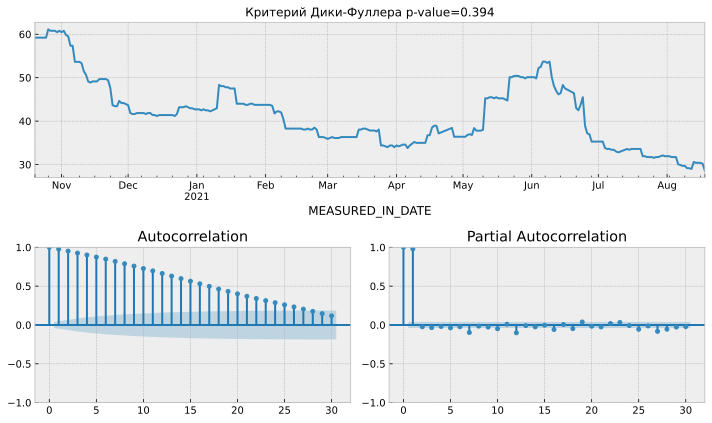

In [44]:
tsplot(data_train['TARGET_OIL_RATE'].dropna(), lags=30)

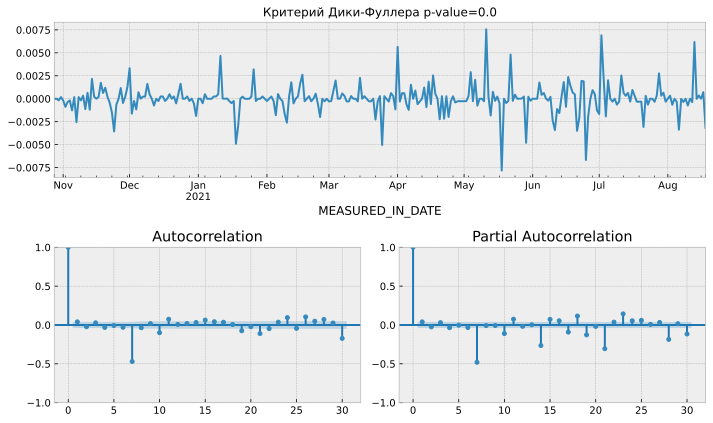

In [45]:
tsplot(data_train['TARGET_OIL_RATE_STATIONARY'].dropna(), lags=30)

In [77]:
ps = range(0, 10)
d = 1
qs = range(0, 10)
Ps = range(0, 10)
D = 1
Qs = range(0, 10)
s = 7

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [78]:
results = []
best_aic = np.inf

for param in tqdm(parameters_list, colour='green'):
    
    try:
        model = sm.tsa.statespace.SARIMAX(endog=data_train['TARGET_OIL_RATE_STATIONARY'], 
                                          order=(param[0], d, param[1]), 
                                          seasonal_order=(param[2], D, param[3], s),).fit(disp=-1, njobs=-1)
    except ValueError:
        print(f'wrong parameters {param}')
        continue
    aic = model.aic
    
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, aic])
    
result_table = pd.DataFrame(results, columns=['PARAMETERS', 'AIC'])
result_table.sort_values(by='AIC').head()

  1%|▌                                                                           | 68/10000 [06:48<16:34:10,  6.01s/it]


KeyboardInterrupt: 

In [80]:
best_model = sm.tsa.statespace.SARIMAX(endog=data_train['TARGET_OIL_RATE_STATIONARY'], 
                                          order=(best_param[0], d, best_param[1]), 
                                          seasonal_order=(best_param[2], D, best_param[3], s)).fit()
print(best_model.summary())
print(best_param)

                                             SARIMAX Results                                              
Dep. Variable:                         TARGET_OIL_RATE_STATIONARY   No. Observations:                  303
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2, 3, 4, 5, 6], 7)   Log Likelihood                1342.252
Date:                                            Mon, 01 May 2023   AIC                          -2670.504
Time:                                                    16:40:56   BIC                          -2644.695
Sample:                                                10-20-2020   HQIC                         -2660.170
                                                     - 08-18-2021                                         
Covariance Type:                                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

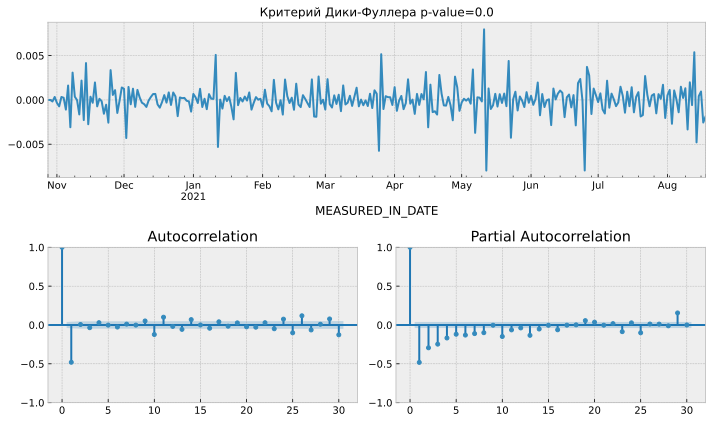

In [81]:
tsplot(best_model.resid[7:].dropna(), lags=30)

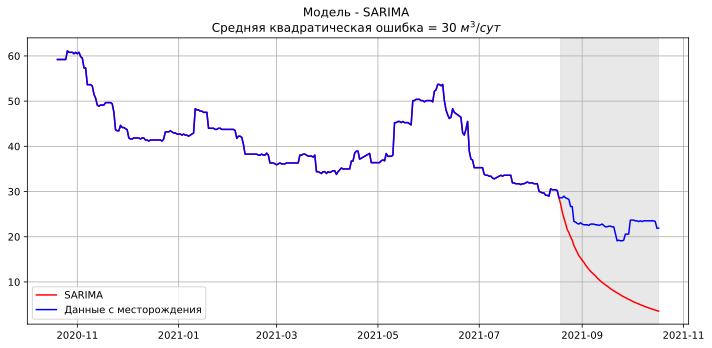

In [82]:
data_train['SARIMA_MODEL'] = best_model.fittedvalues
data_test['SARIMA_MODEL_FORECAST'] = best_model.predict(star=data_train.shape[0], end=data_train.shape[0] + test_size)

forecast = pd.concat([data_train['TARGET_OIL_RATE_STATIONARY'], data_test['SARIMA_MODEL_FORECAST']])
forecast_station = un_stationary(forecast, lmbda_yj, n_elem, n_elements)
data['SARIMA_MODEL_FORECAST'] = forecast_station



plt.figure(figsize=(10, 5));
plt.plot(data['SARIMA_MODEL_FORECAST'], color='r', label="SARIMA")
plt.title(f"Модель - SARIMA \n" 
          f"Средняя квадратическая ошибка "
          f"= {round(mean_squared_error(data['TARGET_OIL_RATE'], data['SARIMA_MODEL_FORECAST']))} $м^{3}/сут$ ")
plt.plot(data['TARGET_OIL_RATE'], color='blue', label="Данные с месторождения")
plt.legend()
plt.axvspan(xmin=data.index[-1] , 
            xmax=data.index[- test_size], 
            alpha=0.5, 
            color='lightgrey')
plt.grid(True)
plt.tight_layout()